# Testiranje granica sustava kod obrade nizova

U ovoj bilježnici biti će ispitano:
* koliko vremena je potrebno za obradu 1. epohe skupa podataka, sličnog mojem, primjenom sekvencijalnih modela
* kako u to ukomponirati operacije maskiranja

In [1]:
import tensorflow as tf
import numpy as np

### Funkcija za generiranje sekvencijalnih podataka proizvoljne dimenzionalnosti

In [2]:
def video_data_generator(num_samples, feature_dim=2048, min_len=200, max_len=450):
    '''Vraća sekvencijalni skup podataka proizvoljne dimenzionalnosti vremenskog koraka,
    sa različitim slučajno generiranim brojem vremenskih koraka pojedinih opažanja.
    
    Argumenti:
    ----------
    num_samples: int
    Broj opažanja.
    
    feature_dim: int
    Dimenzionalnost svakog vremenskog koraka.
    
    min_len: int
    Minimalna broj vremenskih koraka pojedinog opažanja.
    
    max_len: int
    Maksimalni broj vremenskih koraka pojedinog opažanja.
    
    Povratna vrijednost:
    --------------------
    X, y: tuple(list(np.array), list(np.array))
    Skup podataka i oznaka definiranih karakteristika
    '''
    #Generiranje broja vremenskih koraka pojedinog opažanja
    seq_lengths = np.random.randint(min_len, max_len + 1, size=num_samples)
    #Generiranja skupa opažanja
    X = [np.random.randint(0, 256, (seq_lengths[sample], feature_dim)).astype("int32") for sample in range(num_samples)]
    #Normalizacija opažanja
    X = [(sample / 255.).astype("float32") for sample in X]
    #Generiranje oznaka
    y = [np.random.randint(0, 10, size=seq_lengths[sample]).astype("int32") for sample in range(num_samples)]
    #Izvlačenje podatka o veličini generiranog skupa opažanja
    data_size = np.sum([sample.nbytes / 1e6 for sample in X])
    #Ispis informacije o težini skupa podataka u MB-ima
    print(f"Generiran skup podataka sa {num_samples} opažanja, veličine: {data_size:.2f} MB")
    
    return X, y

###  Funkcija za izvlačenje duljina nizova iz generiranih podataka

In [3]:
def get_seq_lengths(data, only_min_max=False):
    '''Ispisuje broj vremenskih koraka svakog opažanja 
    ili samo najmanji i najveći broj vremenskih korak u skupu podataka'''
    
    lengths = [len(sample) for sample in data]
    if only_min_max:
        min_max = np.min(lengths), np.max(lengths)
        print(min_max)
    else:
        print(lengths)

### Funkcija za generiranje Dataseta, sa nadopunjenim batchevima

In [4]:
def build_dataset(X, y, batch_size):
    '''Vraća tf.data.Dataset na temelju ulaznih podataka i oznaka u np.array formatu, 
    sa dinamičkom nadopunom mini grupa'''
    
    #Ovdje je potrebno napraviti generator jer su opažanja različitih duljina, 
    #Kada se podatci podižu iz TFRecorda formata nije potrebno koristiti generator
    ds = tf.data.Dataset.from_generator(lambda: iter(zip(X, y)), 
                                       output_types=(tf.float32, tf.int32))
    
    #Potrebno je dati oznaku nadopunjavanja i za X i y 
    #(.) je bitna zbog toga jer jer tip podatka FLOAT
    #Oznaka nadopuna za y mora biti 0, (inače ne radi: nan kod izračuna funkcije gubitka)
    #bez obzira da li u skup podataka postoji oznaka 0, (nema utjecaj jer će nadopune biti maskirane!)
    ds = ds.padded_batch(batch_size, padded_shapes=([None, 2048], [None]), padding_values=(10., 0))
    
    return ds.prefetch(tf.data.experimental.AUTOTUNE)

### Funkcija za generiranje kompajliranog modela za obradu nizova

In [271]:
def uncompiled_model(num_units=512, bidirect=False):
    '''Definiranje testnih modela'''
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    ulaz = tf.keras.Input(shape=(None, 2048))
    mask = tf.keras.layers.Masking(mask_value=(10.), input_shape=(None, 2048))(ulaz)
    if bidirect:
        srednji = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units, return_sequences=True))(mask)
    else:
        srednji = tf.keras.layers.LSTM(num_units, return_sequences=True)(mask)
    izlaz = tf.keras.layers.Dense(10, activation="softmax")(srednji)
    
    model = tf.keras.Model(inputs=ulaz, outputs=izlaz) 
    return model

#### Testiranje funkcije

Provjera da li se maske propagiraju do zadnjeg sloja, preduvjet je da se dimenzionalnost vremenskog koraka ne mijenja!!!

In [6]:
test_model = uncompiled_model()
for num, layer in enumerate(test_model.layers):
    print(f"Sloj broj {num}: {layer}")
    print(f"Dimenzije ulazne maske: {layer.input_mask}")
    print(f"Dimenzije izlazne maske: {layer.output_mask}")

Sloj broj 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A0D2B75F88>
Dimenzije ulazne maske: None
Dimenzije izlazne maske: None
Sloj broj 1: <tensorflow.python.keras.layers.core.Masking object at 0x000001A0CE64D048>
Dimenzije ulazne maske: None
Dimenzije izlazne maske: Tensor("masking/Identity_1:0", shape=(None, None), dtype=bool)
Sloj broj 2: <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001A0D6E164C8>
Dimenzije ulazne maske: Tensor("masking/Identity_1:0", shape=(None, None), dtype=bool)
Dimenzije izlazne maske: Tensor("masking/Identity_1:0", shape=(None, None), dtype=bool)
Sloj broj 3: <tensorflow.python.keras.layers.core.Dense object at 0x000001A0D6DEB348>
Dimenzije ulazne maske: Tensor("masking/Identity_1:0", shape=(None, None), dtype=bool)
Dimenzije izlazne maske: Tensor("masking/Identity_1:0", shape=(None, None), dtype=bool)


Maska je propagirana do kraja.

### Funkcija koja vraća kompajlirani model

In [272]:
def build_compiled_model(num_units=512, bidirect=False, loss = tf.keras.losses.SparseCategoricalCrossentropy()):
    '''Vraća kompajlirani model sa proizvoljno definiranom funkcijom cilja'''
    
    model = uncompiled_model(num_units, bidirect)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(),
                 loss = loss)
    
    return model

## Testiranje izlaza iz modela sa različitim funkcijama gubitka

### Definiranje pokusnog uzorka uz manualno nadopunjavanje

In [13]:
#Generiranje uzorka
X, y = video_data_generator(1, min_len=5, max_len=10)
print(X[0].shape, y[0].shape)

Generiran skup podataka sa 1 opažanja, veličine: 0.06 MB
(7, 2048) (7,)


In [15]:
#Ukupni broj vremenskih koraka sa nadopunama
padded_sample_len = 40

Prethodnim testiranjima došao sam do zaključka da nadopuna opažanja može biti bilo koji broj, uz uvjet da je odgovarajućeg tipa (npr. float32). Također se pokazalo da nadopuna oznaka **ne može** biti bilo kakav broj npr. -10 ili 10 jer tada u slučaju korištenja `SparseCategoricalCrossentropy` gubitka nije moguće dobiti riješenje i povratna vrijednost je `nan`.

In [16]:
#Kreiranje uzorka koji je nadopunjen sa mask_value=10.
X_test = np.full((padded_sample_len, 2048) , fill_value=10.)
#Dodavanje generiranog uzorka u nadopunu
X_test[:X[0].shape[0]] = X[0]
#Dodavanje batch dimenzije, preduvjet framework-a 
X_test = np.expand_dims(X_test, axis=0)

#Sličana postupak za oznake uz mask_value=0
y_test = np.full(padded_sample_len, fill_value=0)
y_test[:y[0].shape[0]] = y[0] 
y_test = np.expand_dims(y_test, axis=0)

print(X_test.shape, y_test.shape)

(1, 40, 2048) (1, 40)


Dodatno je potrebno napraviti i skup oznaka u one-hot formatu kako bi testirali `CategoricalCrossentropy` gubitak. Razlika između `SparseCategoricalCrossentropy` i `CategoricalCrossentropy` gubitka je u ulaznom sučelju, a oba gubitka računaju isti gubitak.

In [19]:
#Broj klasa odgovara broju klasa BEZ nadopune. Npr. 10 oznaka + 1 nadopuna -> num_classes = 10, a NE 11, inače izlaz ne odgovara!!!!
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

Nadopuna je dobila oznaku klase 0

In [20]:
#Nadopuna kreće od 9 vremenskog koraka
y_test_one_hot[:,8]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

**Testiranje modela sa `CategoricalCrossentropy` gubitkom**

In [21]:
cce_model = build_compiled_model(loss=tf.keras.losses.CategoricalCrossentropy())

Iz ovog se vidi da kod one-hot kodiranja ne možemo uvesti novu oznaku za nadopunu jer bi tada dimenzija izlaza bila `(None, None, 11)` što ne odgovara dimenzionalnosti izlaza modela.

In [22]:
cce_model.output

<tf.Tensor 'dense/Identity:0' shape=(None, None, 10) dtype=float32>

Usporedba predikcije iz modela za uzorak sa nadopunom i bez nadopune

In [23]:
cce_preds_no_pad = cce_model.predict(np.expand_dims(X[0], axis=0))
cce_preds_pad = cce_model.predict(X_test)

In [24]:
cce_preds_pad

array([[[0.09995514, 0.09969988, 0.10154733, 0.08104198, 0.09825476,
         0.09161735, 0.10119843, 0.1195888 , 0.10263669, 0.10445961],
        [0.09745356, 0.10515334, 0.10215287, 0.06633065, 0.09931501,
         0.09968754, 0.1103203 , 0.10579999, 0.11028451, 0.10350222],
        [0.09265828, 0.12462161, 0.10300116, 0.0677657 , 0.09832843,
         0.10694425, 0.10555641, 0.09413032, 0.10330889, 0.10368495],
        [0.10811888, 0.10450601, 0.08996869, 0.06142593, 0.08975842,
         0.09444078, 0.16066778, 0.08711001, 0.10183918, 0.10216431],
        [0.09558361, 0.11254033, 0.10109298, 0.05856425, 0.09472121,
         0.09921907, 0.14864397, 0.09308051, 0.11157166, 0.0849824 ],
        [0.09601758, 0.13491732, 0.10186077, 0.05381562, 0.09501486,
         0.09428658, 0.15381056, 0.08110823, 0.1041777 , 0.08499079],
        [0.10507908, 0.1462904 , 0.09642147, 0.0588892 , 0.09901195,
         0.08644252, 0.1404274 , 0.06686535, 0.11928383, 0.08128884],
        [0.09079527, 0.1509

Na mjestim gdje je nadopuna model kao predikciju vraća 0.1, ali će biti pokazano da je gubitak na tim mjestima zanemaren tj. jednak je nuli ako primjenimo maskiranje.

In [25]:
#Provjera da je predikcija ista ako zanemarimo nadopunjena mjesta (sva poslije 8 opažanja)
(cce_preds_pad[:,:8] == cce_preds_no_pad).all()

True

Iznos funkcije gubitka za uzorak sa nadopunom i bez nadopune, čovjek bi očekivao da su isti ali slijedi iznenađenje.

In [26]:
y_not_padded = y[0]
y_not_padded = tf.keras.utils.to_categorical(y_not_padded, num_classes=10)
y_not_padded = np.expand_dims(y_not_padded, axis=0)

In [27]:
cce_loss_no_pad = cce_model.evaluate(np.expand_dims(X[0], axis=0), y_not_padded)
cce_loss_no_pad

1/1 [==============================] - 1s 1s/sample - loss: 2.3552


2.355224847793579

In [28]:
cce_loss_pad = cce_model.evaluate(X_test, y_test_one_hot)

1/1 [==============================] - 1s 1s/sample - loss: 0.4710


Postavlja se pitanja zašto postoji ova razlika u iznosu funkcije cilja kada znamo da se uzorci razlikuju samo u broju vremenskih koraka - bez nadopune broj koraka je 8, a sa njom je 40. Ako dobro pogledamo iznose funkcije gubitka vidjet ćemo da je njihov omjer upravo 40/8 = 5 !!!
Kroz ručnu provjeru moguće je pokazati da je to upravo ono što se događa kod izračuna vrijednosti funkcije gubitka. Ovo nije očekivano ponašanje jer na taj način jedan te isti uzorak može različito djelovati na iznos funkcije gubitka ovisno o tome u kojoj mini grupi se nalazi. Ako se nalazi u mini grupi koja ima veću nadopunu tada će iznose funkcije cilja biti manje nego ako je u grupi koja ima manju nadopunu.

In [29]:
#Ručna provjera - bez nadopune
-np.sum(y_not_padded * np.log(cce_preds_no_pad))/8

2.355224847793579

Kada nema nadopune očekivanje funkcije gubitka u nazivniku ima (broj opažanja * broj vremenskih koraka) = 1 * 8 = 8

In [30]:
#Ručna provjera - sa nadopunom (uz maskiranje zato je :8!!)
-np.sum(y_test_one_hot[:,:8] * np.log(cce_preds_pad[:,:8]))/40

0.47104496955871583

Uz dodanu nadopunu očekivanje funkcije gubitka u nazivniku ima 40.
Još jednom napominjem ovo nije očekivano ponašanje, ali na kraju nema utjecaj na učenje modela jer se ovaj iznos nigdje ne koristi, ali mi kao korisnici dobivamo pogrešnu informaciju.

U nastavku ću pokazati da naš model zaista u obzir uzima masku prilikom izračuna funkcije gubitka za nadopunjeni uzorak.

In [31]:
#Izračun iznosa funkcije gubitka za nadopunjeni uzorak bez maske
no_mask_loss = tf.keras.losses.CategoricalCrossentropy()
no_mask_loss(y_test_one_hot, cce_preds_pad).numpy() 

2.313113

In [32]:
#Kako se došlo do ove brojke
- np.sum(y_test_one_hot * np.log(cce_preds_pad))/40

2.3131130218505858

Ovdje se vidi da su obzir uzete i one 0.1 vrijednosti koje model pokazuje za nadopune, te s obzirom da su oznake nadopuna iste kao i za klasu 0 sve je uračunato u gubitak.

In [33]:
#Izračun iznosa funkcije gubitka za nadopunjeni uzorak sa maskom
cce_model.evaluate(X_test, y_test_one_hot)

1/1 [==============================] - 0s 81ms/sample - loss: 0.4710


0.47104495763778687

Kada je maska uzeta u obzir ovo je iznos gubitka.

**Testiranje modela sa `SparseCatgoricalCrossentropy` gubitkom**

In [35]:
sparse_model = build_compiled_model(loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [36]:
#Predikcija iz modela sa nadopunjavanjem i bez nadopunjavanja
sparse_model_preds_no_pad = sparse_model.predict(np.expand_dims(X[0], axis=0))
sparse_model_preds_pad = sparse_model.predict(X_test)

(sparse_model_preds_no_pad == sparse_model_preds_pad[:,:8]).all()

True

In [37]:
sparse_model_preds_pad

array([[[0.09995514, 0.09969988, 0.10154733, 0.08104198, 0.09825476,
         0.09161735, 0.10119843, 0.1195888 , 0.10263669, 0.10445961],
        [0.09745356, 0.10515334, 0.10215287, 0.06633065, 0.09931501,
         0.09968754, 0.1103203 , 0.10579999, 0.11028451, 0.10350222],
        [0.09265828, 0.12462161, 0.10300116, 0.0677657 , 0.09832843,
         0.10694425, 0.10555641, 0.09413032, 0.10330889, 0.10368495],
        [0.10811888, 0.10450601, 0.08996869, 0.06142593, 0.08975842,
         0.09444078, 0.16066778, 0.08711001, 0.10183918, 0.10216431],
        [0.09558361, 0.11254033, 0.10109298, 0.05856425, 0.09472121,
         0.09921907, 0.14864397, 0.09308051, 0.11157166, 0.0849824 ],
        [0.09601758, 0.13491732, 0.10186077, 0.05381562, 0.09501486,
         0.09428658, 0.15381056, 0.08110823, 0.1041777 , 0.08499079],
        [0.10507908, 0.1462904 , 0.09642147, 0.0588892 , 0.09901195,
         0.08644252, 0.1404274 , 0.06686535, 0.11928383, 0.08128884],
        [0.09079527, 0.1509

Možemo se uvjeriti da je predikcija iz cce_modela i sparse_modela ista 

In [38]:
(sparse_model_preds_pad == cce_preds_pad).all()

True

Sada ćemo provjeriti iznos funkcije gubitka, za slučaj nadopune i bez

In [39]:
sparse_model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/sample - loss: 0.4710


0.47104495763778687

Gubitak je apsolutno isti kao i za cce model.

Bez maskiranja gubitak bi bio kako je prikazano dolje

In [40]:
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy()
sparse_loss(tf.convert_to_tensor(y_test), tf.convert_to_tensor(sparse_model_preds_pad))

<tf.Tensor: shape=(), dtype=float32, numpy=2.313113>

**Važna napomena** kod primjene `SparseCategoricalCrossentropy` gubitka oznaka nadopune za y mora biti 0, probao sam i oznake poput -10 i 10, ali tada izlaz bude `nan`.

**Testiranje modela sa `SparseCategoricalCrossentropy` gubitkom i `tf.data.Dataset`-om za generiranje opažanja**

Idemo sada vidjeti da li ovo nadopunjavanje radi sa `tf.data.Dataset`.

In [41]:
def test_build_dataset(X, y):
    ds = tf.data.Dataset.from_generator(lambda: iter(zip(X, y)), 
                                       output_types=(tf.float32, tf.int32))
    #U testnu funkciju stavit ću duljinu nadopuna na 40 i batch da bude 1
    ds = ds.padded_batch(1, padded_shapes=([40, 2048], [40]), padding_values=(10., 0))
    
    return ds.prefetch(tf.data.experimental.AUTOTUNE)

In [42]:
#Generiranje skupa podataka
test_dataset = test_build_dataset(X[:2], y[:2])

In [43]:
for element in test_dataset.take(1): print(element)

(<tf.Tensor: shape=(1, 40, 2048), dtype=float32, numpy=
array([[[5.7254905e-01, 2.3529412e-02, 2.0000000e-01, ...,
         5.6862748e-01, 1.9215687e-01, 2.3529412e-01],
        [6.6666670e-02, 5.6078434e-01, 4.7450981e-01, ...,
         6.4313728e-01, 7.1372551e-01, 4.4705883e-01],
        [3.9215689e-03, 9.8039217e-02, 8.0784315e-01, ...,
         8.9411765e-01, 8.3137256e-01, 6.4705884e-01],
        ...,
        [1.0000000e+01, 1.0000000e+01, 1.0000000e+01, ...,
         1.0000000e+01, 1.0000000e+01, 1.0000000e+01],
        [1.0000000e+01, 1.0000000e+01, 1.0000000e+01, ...,
         1.0000000e+01, 1.0000000e+01, 1.0000000e+01],
        [1.0000000e+01, 1.0000000e+01, 1.0000000e+01, ...,
         1.0000000e+01, 1.0000000e+01, 1.0000000e+01]]], dtype=float32)>, <tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[3, 9, 4, 5, 7, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>)


Idemo ubaciti to jedno opažanje u model

In [44]:
sparse_model.evaluate(test_dataset.take(1))

      1/Unknown - 1s 1s/step - loss: 0.4710

0.47104495763778687

Juhu radi!!!!!!!!!!!!

In [268]:
X, y = video_data_generator(2, min_len=5, max_len=10)
print(X[1].shape, y[1].shape)

Generiran skup podataka sa 2 opažanja, veličine: 0.09 MB
(5, 2048) (5,)


In [262]:
def test_build_dataset(X, y):
    ds = tf.data.Dataset.from_generator(lambda: iter(zip(X, y)), 
                                       output_types=(tf.float32, tf.int32))
    #U testnu funkciju stavit ću duljinu nadopuna na 40 i batch da bude 1
    ds = ds.padded_batch(2, padded_shapes=([40, 2048], [40]), padding_values=(10., 0))
    
    return ds.prefetch(tf.data.experimental.AUTOTUNE)

In [376]:
test_dataset = test_build_dataset(X[:2], y[:2])

In [273]:
sparse_model =  build_compiled_model()

In [282]:
preds_1 = sparse_model(np.expand_dims(X[0], axis=0))
preds_2 = sparse_model(np.expand_dims(X[1], axis=0))

In [374]:
preds_1

<tf.Tensor: shape=(1, 5, 10), dtype=float32, numpy=
array([[[0.11001404, 0.10552107, 0.11830676, 0.07250454, 0.1300758 ,
         0.08186158, 0.09162187, 0.08882565, 0.11286505, 0.0884036 ],
        [0.10079003, 0.12395457, 0.11616632, 0.06710688, 0.12260108,
         0.08293962, 0.11200565, 0.09302557, 0.10201432, 0.07939593],
        [0.10915978, 0.11744958, 0.10832138, 0.05608214, 0.12959936,
         0.0859175 , 0.11381278, 0.08148544, 0.1093683 , 0.08880377],
        [0.09913972, 0.12073839, 0.10789456, 0.05156359, 0.09640401,
         0.10551096, 0.14427568, 0.07249292, 0.10972534, 0.09225475],
        [0.10000954, 0.12706769, 0.11117544, 0.04794908, 0.11150431,
         0.09915347, 0.13889737, 0.07301044, 0.10933805, 0.08189458]]],
      dtype=float32)>

In [375]:
preds_2

<tf.Tensor: shape=(1, 6, 10), dtype=float32, numpy=
array([[[0.11031532, 0.10396454, 0.12393213, 0.08192398, 0.09528198,
         0.11231874, 0.09937397, 0.08504782, 0.08851507, 0.09932642],
        [0.10982328, 0.10981671, 0.13712107, 0.07679864, 0.09113602,
         0.09647083, 0.10478106, 0.08727697, 0.0825411 , 0.10423431],
        [0.10690726, 0.12967923, 0.13622552, 0.06271802, 0.09733277,
         0.10469835, 0.1033857 , 0.08634533, 0.08352528, 0.08918259],
        [0.09195168, 0.12523128, 0.12914595, 0.06617991, 0.08234257,
         0.09659947, 0.14186278, 0.09416312, 0.07972792, 0.09279527],
        [0.0993254 , 0.12681386, 0.11997992, 0.05336834, 0.08062448,
         0.10304878, 0.12498306, 0.09708665, 0.10378332, 0.09098621],
        [0.10185791, 0.1453045 , 0.12836175, 0.05977019, 0.09245957,
         0.08283289, 0.12599616, 0.09342758, 0.09096382, 0.0790257 ]]],
      dtype=float32)>

In [377]:
sparse_model.evaluate(test_dataset)

      1/Unknown - 0s 481ms/step - loss: 0.3230

0.3229535222053528

In [275]:
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [284]:
y_1_oh = tf.keras.utils.to_categorical(y[0], num_classes=10)
y_2_oh = tf.keras.utils.to_categorical(y[1], num_classes=10)

In [378]:
((- np.sum(y_1_oh * np.log(preds_1))/40) + (- np.sum(y_2_oh * np.log(preds_2))/40))/2

0.3229535102844238

Radi i za više opažanja !!

Ovako izgleda propagiranje maske kroz model

In [ ]:
unmasked_sample = test_model.layers[0](test_sample)
masked_sample = test_model.layers[1](unmasked_sample)
masked_2 = test_model.layers[2](masked_sample)
masked_3 = test_model.layers[3](masked_2)
print(masked_3._keras_mask)
print(masked_3)

## Testiranje 1d konvolucijskog modela, 

Poanta je pokazati kako riješiti problem maskiranja, jer 1d konvolucijski slojevi ne podržavaju maskiranje

In [381]:
def tcn_model_no_mask():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    ulaz = tf.keras.Input(shape=(None, 2048))
    srednji = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(ulaz)
    izlaz = tf.keras.layers.Conv1D(10, 1, activation="softmax")(srednji)
    
    model = tf.keras.Model(inputs=ulaz, outputs=izlaz)
    return model

def tcn_model_MASK():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    ulaz = tf.keras.Input(shape=(None, 2048))
    
    mask = tf.keras.layers.Lambda(lambda x: tf.reduce_any(tf.not_equal(x, 10.), axis=-1, keepdims=True))(ulaz)
    mask_float = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(mask)
    
    srednji_1 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(ulaz)
    srednji_2 = tf.keras.layers.Conv1D(10, 1, activation="softmax")(srednji_1)
    
    izlaz = tf.keras.layers.multiply([srednji_2, mask_float])
    
    model = tf.keras.Model(inputs=ulaz, outputs=izlaz)
    
    return model

In [138]:
model_no_mask = tcn_model_no_mask()
model_mask = tcn_model_MASK()

In [294]:
outputs = []
for layer in model_mask.layers:
    outputs.append(layer.output)

In [295]:
outputs

[<tf.Tensor 'input_1:0' shape=(None, None, 2048) dtype=float32>,
 <tf.Tensor 'conv1d/Identity:0' shape=(None, None, 32) dtype=float32>,
 <tf.Tensor 'lambda/Identity:0' shape=(None, None, 1) dtype=bool>,
 <tf.Tensor 'conv1d_1/Identity:0' shape=(None, None, 10) dtype=float32>,
 <tf.Tensor 'lambda_1/Identity:0' shape=(None, None, 1) dtype=float32>,
 <tf.Tensor 'multiply/Identity:0' shape=(None, None, 10) dtype=float32>]

In [296]:
inter_model = tf.keras.Model(inputs=model_mask.input, outputs=outputs)

In [297]:
inter_model(X_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[<tf.Tensor: shape=(1, 40, 2048), dtype=float64, numpy=
 array([[[ 0.82352942,  0.16078432,  0.78431374, ...,  0.99607843,
           0.39215687,  0.01176471],
         [ 0.8392157 ,  0.07450981,  0.70588237, ...,  0.71764708,
           0.60784316,  0.36078432],
         [ 0.69411767,  0.95294118,  0.67450982, ...,  0.65490198,
           0.54901963,  0.67843139],
         ...,
         [10.        , 10.        , 10.        , ..., 10.        ,
          10.        , 10.        ],
         [10.        , 10.        , 10.        , ..., 10.        ,
          10.        , 10.        ],
         [10.        , 10.        , 10.        , ..., 10.        ,
          10.        , 10.        ]]])>,
 <tf.Tensor: shape=(1, 40, 32), dtype=float32, numpy=
 array([[[ 1.2419618 ,  0.        ,  0.        , ...,  0.02798664,
           0.3083924 ,  0.        ],
         [ 0.7955876 ,  0.        ,  0.05573715, ...,  0.        ,
           0.        ,  0.        ],
         [ 1.1923463 ,  0.        ,  0.0

Provjera da li modeli imaju isti broj parametara

In [139]:
model_no_mask.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2048)]      0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          196640    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 10)          330       
Total params: 196,970
Trainable params: 196,970
Non-trainable params: 0
_________________________________________________________________


In [140]:
model_mask.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2048)] 0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     196640      input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 10)     330         conv1d[0][0]                     
______________________________________________________________________________________________

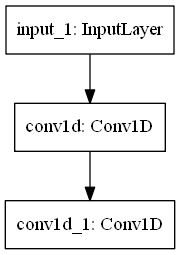

In [141]:
tf.keras.utils.plot_model(model_no_mask)

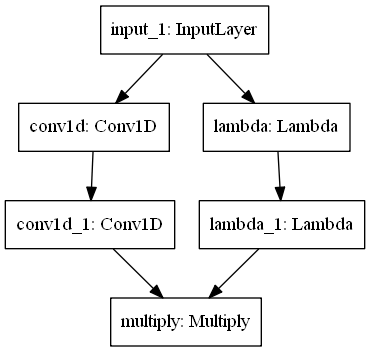

In [142]:
tf.keras.utils.plot_model(model_mask)

Provjera da li su modelima inicijalizirane iste težine

In [51]:
bias1_weights = []
for layer in model_no_mask.layers:
    if layer.weights:
        bias1_weights.append(layer.weights[1].numpy())

In [52]:
bias2_weights = []
for layer in model_mask.layers:
    if layer.weights:
        bias2_weights.append(layer.weights[1].numpy())

In [60]:
del bias1_weights,bias2_weights

In [143]:
m1_weights = []
for layer in model_no_mask.layers:
    if layer.weights:
        m1_weights.append(layer.weights[0].numpy())

In [144]:
m2_weights = []
for layer in model_mask.layers:
    if layer.weights:
        m2_weights.append(layer.weights[0].numpy())

In [145]:
for w1, w2 in zip(m1_weights, m2_weights):
    print((w1 == w2).all())

True
True


In [146]:
del w1, w2

Provjera izlaza iz oba modela za nenadopunjeno opažanje

In [147]:
test_X = np.expand_dims(X[0], axis=0)

In [148]:
test_X[test_X == 10]

array([], dtype=float32)

In [149]:
model_no_mask(test_X)

<tf.Tensor: shape=(1, 8, 10), dtype=float32, numpy=
array([[[0.05990445, 0.06776217, 0.20353526, 0.04912695, 0.084016  ,
         0.14381342, 0.1266416 , 0.09626544, 0.06445209, 0.10448257],
        [0.02692183, 0.05078857, 0.22526759, 0.03899141, 0.09729838,
         0.23714718, 0.10851948, 0.03613634, 0.10728844, 0.07164077],
        [0.05749212, 0.04426674, 0.24291562, 0.05416018, 0.10907574,
         0.17476225, 0.13088168, 0.05536202, 0.05031167, 0.08077204],
        [0.0317529 , 0.06151203, 0.3082013 , 0.03833192, 0.08270654,
         0.18312109, 0.0908005 , 0.06227267, 0.08220038, 0.05910073],
        [0.04573553, 0.03620706, 0.24623159, 0.05685955, 0.11803322,
         0.16205528, 0.13084398, 0.06129059, 0.06287497, 0.07986815],
        [0.03771546, 0.04964134, 0.3441235 , 0.02270965, 0.0751069 ,
         0.22201744, 0.08691013, 0.04476181, 0.04811637, 0.06889736],
        [0.04076022, 0.04896275, 0.3765275 , 0.03594076, 0.06958277,
         0.1536347 , 0.12232693, 0.04571481, 

In [150]:
model_mask(test_X)

<tf.Tensor: shape=(1, 8, 10), dtype=float32, numpy=
array([[[0.05990445, 0.06776217, 0.20353526, 0.04912695, 0.084016  ,
         0.14381342, 0.1266416 , 0.09626544, 0.06445209, 0.10448257],
        [0.02692183, 0.05078857, 0.22526759, 0.03899141, 0.09729838,
         0.23714718, 0.10851948, 0.03613634, 0.10728844, 0.07164077],
        [0.05749212, 0.04426674, 0.24291562, 0.05416018, 0.10907574,
         0.17476225, 0.13088168, 0.05536202, 0.05031167, 0.08077204],
        [0.0317529 , 0.06151203, 0.3082013 , 0.03833192, 0.08270654,
         0.18312109, 0.0908005 , 0.06227267, 0.08220038, 0.05910073],
        [0.04573553, 0.03620706, 0.24623159, 0.05685955, 0.11803322,
         0.16205528, 0.13084398, 0.06129059, 0.06287497, 0.07986815],
        [0.03771546, 0.04964134, 0.3441235 , 0.02270965, 0.0751069 ,
         0.22201744, 0.08691013, 0.04476181, 0.04811637, 0.06889736],
        [0.04076022, 0.04896275, 0.3765275 , 0.03594076, 0.06958277,
         0.1536347 , 0.12232693, 0.04571481, 

In [154]:
tf.reduce_all(model_no_mask(test_X) == model_mask(test_X)).numpy()

True

Zašto izlazi iz ova dva modela nisu isti?

Kada sam definirao model_mask, sa `Masking` layerom nisam dobivao iste izlaze iz oba modela iz razloga što taj sloj vraća svoj ulaz, sa onim komponentama koje odgovaraju mask value u potpunosti u zadnjoj dimenziji na 0.

Zabluda je da vraća masku, to možemo dobiti ako eksplicitno na tom sloju pozovemo metodu `compute_mask` tada vraća `bool` tenzor, ali dimenzije 2D (istisne zadnju dimenziju, zbog definicije `tf.reduce_all` u `Masking` sloju gdje je `keepdims=False`), te onda naknadno je potrebno dodavati tu dimenziju.

Jednostavniji pristup je definirati `Lambda` sloj i kroz njega riješiti pitanje prosljeđivanja maske.

### Fora kako vidjeti izlaze iz svakog sloja

In [111]:
mask_model_layer_outputs = [layer.output for layer in model_mask.layers]

In [112]:
mask_model_layer_outputs

[<tf.Tensor 'input_1:0' shape=(None, None, 2048) dtype=float32>,
 <tf.Tensor 'NotEqual:0' shape=(None, None, 2048) dtype=bool>,
 <tf.Tensor 'conv1d/Identity:0' shape=(None, None, 32) dtype=float32>,
 <tf.Tensor 'Any:0' shape=(None, None) dtype=bool>,
 <tf.Tensor 'conv1d_1/Identity:0' shape=(None, None, 10) dtype=float32>,
 <tf.Tensor 'lambda/Identity:0' shape=(None, None, 1) dtype=float32>,
 <tf.Tensor 'multiply/Identity:0' shape=(None, None, 10) dtype=float32>]

In [113]:
inter1_model = tf.keras.Model(inputs = model_mask.input, outputs=mask_model_layer_outputs)

In [114]:
inter1_model(test_X)

[<tf.Tensor: shape=(1, 8, 2048), dtype=float32, numpy=
 array([[[0.8235294 , 0.16078432, 0.78431374, ..., 0.99607843,
          0.39215687, 0.01176471],
         [0.8392157 , 0.07450981, 0.7058824 , ..., 0.7176471 ,
          0.60784316, 0.36078432],
         [0.69411767, 0.9529412 , 0.6745098 , ..., 0.654902  ,
          0.54901963, 0.6784314 ],
         ...,
         [0.00784314, 0.38039216, 0.972549  , ..., 0.34117648,
          0.34901962, 0.654902  ],
         [0.7294118 , 0.7176471 , 0.9254902 , ..., 0.8039216 ,
          0.99215686, 0.07450981],
         [0.11764706, 0.7411765 , 0.34901962, ..., 0.04313726,
          0.654902  , 0.63529414]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 8, 2048), dtype=bool, numpy=
 array([[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  T

In [134]:
tf.cast(tf.reduce_any(tf.not_equal(X_test, 10.), axis=-1, keepdims=True), tf.float32)

<tf.Tensor: shape=(1, 40, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]], dtype=float32)>

### Usporedba izlaza iz modela sa nadopunjenim uzorcima.

In [383]:
model_no_mask(tf.cast(X_test, tf.float32))

<tf.Tensor: shape=(1, 40, 10), dtype=float32, numpy=
array([[[5.99044524e-02, 6.77621737e-02, 2.03535259e-01, 4.91269454e-02,
         8.40159953e-02, 1.43813416e-01, 1.26641601e-01, 9.62654427e-02,
         6.44520894e-02, 1.04482569e-01],
        [2.69218273e-02, 5.07885739e-02, 2.25267589e-01, 3.89914066e-02,
         9.72983763e-02, 2.37147182e-01, 1.08519480e-01, 3.61363366e-02,
         1.07288443e-01, 7.16407672e-02],
        [5.74921183e-02, 4.42667417e-02, 2.42915615e-01, 5.41601777e-02,
         1.09075740e-01, 1.74762249e-01, 1.30881682e-01, 5.53620160e-02,
         5.03116660e-02, 8.07720423e-02],
        [3.17528956e-02, 6.15120269e-02, 3.08201313e-01, 3.83319184e-02,
         8.27065408e-02, 1.83121085e-01, 9.08005014e-02, 6.22726716e-02,
         8.22003782e-02, 5.91007285e-02],
        [4.57355343e-02, 3.62070575e-02, 2.46231586e-01, 5.68595529e-02,
         1.18033223e-01, 1.62055284e-01, 1.30843982e-01, 6.12905882e-02,
         6.28749728e-02, 7.98681527e-02],
       

In [160]:
model_mask(tf.cast(X_test, tf.float32))

<tf.Tensor: shape=(1, 40, 10), dtype=float32, numpy=
array([[[5.9904452e-02, 6.7762174e-02, 2.0353526e-01, 4.9126945e-02,
         8.4015995e-02, 1.4381342e-01, 1.2664160e-01, 9.6265443e-02,
         6.4452089e-02, 1.0448257e-01],
        [2.6921827e-02, 5.0788574e-02, 2.2526759e-01, 3.8991407e-02,
         9.7298376e-02, 2.3714718e-01, 1.0851948e-01, 3.6136337e-02,
         1.0728844e-01, 7.1640767e-02],
        [5.7492118e-02, 4.4266742e-02, 2.4291562e-01, 5.4160178e-02,
         1.0907574e-01, 1.7476225e-01, 1.3088168e-01, 5.5362016e-02,
         5.0311666e-02, 8.0772042e-02],
        [3.1752896e-02, 6.1512027e-02, 3.0820131e-01, 3.8331918e-02,
         8.2706541e-02, 1.8312109e-01, 9.0800501e-02, 6.2272672e-02,
         8.2200378e-02, 5.9100728e-02],
        [4.5735534e-02, 3.6207058e-02, 2.4623159e-01, 5.6859553e-02,
         1.1803322e-01, 1.6205528e-01, 1.3084398e-01, 6.1290588e-02,
         6.2874973e-02, 7.9868153e-02],
        [3.7715465e-02, 4.9641341e-02, 3.4412351e-01, 2.2

### Izračun funkcije gubitka iz ovih modela

In [161]:
#Kompajliranje mask i no_mask modela
model_mask.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy())
model_no_mask.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [180]:
X_test.shape, y_test[:,:8].shape

((1, 40, 2048), (1, 8))

In [176]:
#Izračun gubitka sa ne nadopunjenim opažanjem
model_mask.evaluate(X_test[:,:8,:], y_test[:,:8])

1/1 [==============================] - 0s 291ms/sample - loss: 2.4075


2.4074602127075195

In [177]:
model_no_mask.evaluate(X_test[:,:8,:], y_test[:,:8])

1/1 [==============================] - 0s 289ms/sample - loss: 2.4075


2.4074602127075195

In [384]:
#Izračun gubitka sa nadopunjenim opažanjem
model_mask.evaluate(X_test, y_test)

1/1 [==============================] - 0s 169ms/sample - loss: 2.5277


2.527740001678467

In [393]:
y_test.shape

(1, 40)

In [385]:
model_no_mask.evaluate(X_test, y_test)

1/1 [==============================] - 0s 200ms/sample - loss: 13.5801


13.580148696899414

In [372]:
model_no_mask.predict(test_dataset)

array([[[3.04370653e-02, 9.31522995e-02, 1.99914932e-01, 3.33367959e-02,
         1.16511151e-01, 1.55505493e-01, 7.51380995e-02, 9.24233571e-02,
         6.47187904e-02, 1.38861999e-01],
        [7.34077618e-02, 4.23050113e-02, 3.05110008e-01, 2.40864977e-02,
         6.76638633e-02, 2.17707217e-01, 1.18670329e-01, 5.03504500e-02,
         4.45234068e-02, 5.61755486e-02],
        [5.77752106e-02, 6.13865107e-02, 2.07607314e-01, 5.19828871e-02,
         8.69373977e-02, 1.78612456e-01, 1.58805996e-01, 6.99861571e-02,
         4.85016070e-02, 7.84044415e-02],
        [3.89075764e-02, 7.37654418e-02, 3.32891375e-01, 4.04097401e-02,
         5.20612001e-02, 1.78610712e-01, 8.82541537e-02, 7.25515410e-02,
         5.70828579e-02, 6.54654503e-02],
        [7.65989353e-06, 2.00720515e-05, 2.78632879e-01, 2.46261563e-02,
         9.21242230e-04, 1.63094560e-03, 6.92873359e-01, 4.21523100e-06,
         1.26525993e-03, 1.82434924e-05],
        [1.84426389e-12, 1.38674253e-10, 9.99869466e-01, 5.6

### Manualni izračun gubitka za nadopunjeni i nenadopunjeni uzorak

In [411]:
#Nenadopunjeni opažanje - predikcija
preds_no_mask = model_no_mask.predict(X_test[:,:8,:])
preds_mask = model_mask.predict(X_test[:,:8,:])

In [194]:
oh_y_8 = tf.keras.utils.to_categorical(y_test[:,:8])
print(-np.sum(oh_y_8 * np.log(preds_no_mask))/8)
print(-np.sum(oh_y_8 * np.log(preds_mask))/8)

2.4074602127075195
2.4074602127075195


In [412]:
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy()
sparse_loss(tf.convert_to_tensor(y_test[:,:8]), tf.convert_to_tensor(preds_no_mask))

<tf.Tensor: shape=(), dtype=float32, numpy=2.4074602>

In [413]:
cce_loss = tf.keras.losses.CategoricalCrossentropy()
cce_loss(oh_y_8, preds_no_mask)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4074605>

In [414]:
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy()
sparse_loss(tf.convert_to_tensor(y_test[:,:8]), tf.convert_to_tensor(preds_mask))

<tf.Tensor: shape=(), dtype=float32, numpy=2.4074602>

In [415]:
cce_loss = tf.keras.losses.CategoricalCrossentropy()
cce_loss(oh_y_8, preds_mask)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4074605>

In [410]:
X_test[:,:8]

array([[[0.82352942, 0.16078432, 0.78431374, ..., 0.99607843,
         0.39215687, 0.01176471],
        [0.8392157 , 0.07450981, 0.70588237, ..., 0.71764708,
         0.60784316, 0.36078432],
        [0.69411767, 0.95294118, 0.67450982, ..., 0.65490198,
         0.54901963, 0.67843139],
        ...,
        [0.00784314, 0.38039216, 0.97254902, ..., 0.34117648,
         0.34901962, 0.65490198],
        [0.72941178, 0.71764708, 0.9254902 , ..., 0.80392158,
         0.99215686, 0.07450981],
        [0.11764706, 0.74117649, 0.34901962, ..., 0.04313726,
         0.65490198, 0.63529414]]])

In [416]:
#Nadopunjena opažanje - predikcija
preds_no_mask = model_no_mask.predict(X_test)
preds_mask = model_mask.predict(X_test)

In [417]:
preds_no_mask[:,:8] == preds_mask[:,:8]

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]]])

In [418]:
model_no_mask.evaluate(X_test, y_test)

1/1 [==============================] - 0s 81ms/sample - loss: 13.5801


13.580148696899414

In [419]:
model_mask.evaluate(X_test, y_test)

1/1 [==============================] - 0s 83ms/sample - loss: 2.5277


2.527740001678467

In [216]:
preds_mask.sum(axis=-1)

array([[1.0000001, 1.       , 1.0000001, 1.       , 0.9999999, 1.       ,
        1.       , 0.9999998, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ]], dtype=float32)

Ovo je problem jer će kod izračuna f. gubitka np.log(0) = nan !

In [408]:
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy()
sparse_loss(tf.convert_to_tensor(y_test), tf.convert_to_tensor(preds_no_mask))

<tf.Tensor: shape=(), dtype=float32, numpy=13.580149>

In [409]:
cce_loss = tf.keras.losses.CategoricalCrossentropy()
cce_loss(oh_y_40, preds_no_mask)

<tf.Tensor: shape=(), dtype=float32, numpy=13.580149>

### Model 2

In [525]:
class MaskConv1D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskConv1D, self).__init__(**kwargs)
        #Omogućava propagiranje maske
        self.supports_masking = True
    
    #def call(self, inputs):
        #return inputs
    #Omogućava prijem maske
    def call(self, inputs, mask=None):
        broadcast_float_mask = tf.expand_dims(tf.cast(mask, "float32"), -1)
        masked_inputs = inputs * broadcast_float_mask   
        return masked_inputs


In [526]:
def conv_1D_MASK_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    ulaz = tf.keras.Input(shape=(None, 2048))
    
    #mask = tf.keras.layers.Masking(mask_value=10.).compute_mask(ulaz)
    mask = tf.keras.layers.Lambda(lambda x: tf.reduce_any(tf.not_equal(x, 10.), axis=-1))(ulaz)
    
    srednji_1 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(ulaz)
    srednji_2 = tf.keras.layers.Conv1D(10, 1, activation="softmax")(srednji_1)
    
    izlaz = MaskConv1D()(srednji_2, mask=mask)
    
    model = tf.keras.Model(inputs=ulaz, outputs=izlaz)
    
    return model

In [527]:
model_2 = conv_1D_MASK_model()

In [528]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2048)] 0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     196640      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 10)     330         conv1d[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
______________________________________________________________________________________________

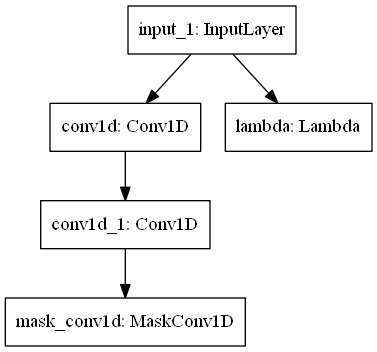

In [529]:
tf.keras.utils.plot_model(model_2)

In [530]:
model_2.predict(X_test)

array([[[5.99044636e-02, 6.77621886e-02, 2.03535259e-01, 4.91269566e-02,
         8.40160102e-02, 1.43813431e-01, 1.26641616e-01, 9.62654501e-02,
         6.44520968e-02, 1.04482584e-01],
        [2.69218236e-02, 5.07885702e-02, 2.25267619e-01, 3.89914028e-02,
         9.72983763e-02, 2.37147197e-01, 1.08519480e-01, 3.61363329e-02,
         1.07288450e-01, 7.16407746e-02],
        [5.74921183e-02, 4.42667417e-02, 2.42915615e-01, 5.41601777e-02,
         1.09075740e-01, 1.74762219e-01, 1.30881682e-01, 5.53620160e-02,
         5.03116660e-02, 8.07720423e-02],
        [3.17528881e-02, 6.15120158e-02, 3.08201253e-01, 3.83319110e-02,
         8.27065408e-02, 1.83121040e-01, 9.08005163e-02, 6.22726716e-02,
         8.22003782e-02, 5.91007285e-02],
        [4.57355268e-02, 3.62070575e-02, 2.46231586e-01, 5.68595454e-02,
         1.18033215e-01, 1.62055284e-01, 1.30843982e-01, 6.12905882e-02,
         6.28749654e-02, 7.98681527e-02],
        [3.77154686e-02, 4.96413447e-02, 3.44123542e-01, 2.2

In [541]:
#Radi i sa CategoricalCrossentropy-em
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [543]:
pred_2 = model_2.predict(test_dataset)

In [544]:
pred_2

array([[[3.0437065e-02, 9.3152300e-02, 1.9991493e-01, 3.3336796e-02,
         1.1651115e-01, 1.5550549e-01, 7.5138099e-02, 9.2423357e-02,
         6.4718790e-02, 1.3886200e-01],
        [7.3407762e-02, 4.2305011e-02, 3.0511001e-01, 2.4086498e-02,
         6.7663863e-02, 2.1770722e-01, 1.1867033e-01, 5.0350450e-02,
         4.4523407e-02, 5.6175549e-02],
        [5.7775211e-02, 6.1386511e-02, 2.0760731e-01, 5.1982887e-02,
         8.6937398e-02, 1.7861246e-01, 1.5880600e-01, 6.9986157e-02,
         4.8501607e-02, 7.8404441e-02],
        [3.8907576e-02, 7.3765442e-02, 3.3289137e-01, 4.0409740e-02,
         5.2061200e-02, 1.7861071e-01, 8.8254154e-02, 7.2551541e-02,
         5.7082858e-02, 6.5465450e-02],
        [7.6598935e-06, 2.0072051e-05, 2.7863288e-01, 2.4626156e-02,
         9.2124223e-04, 1.6309456e-03, 6.9287336e-01, 4.2152310e-06,
         1.2652599e-03, 1.8243492e-05],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.

In [545]:
model_2.evaluate(test_dataset)

      1/Unknown - 0s 343ms/step - loss: 0.4980

0.4979720711708069

In [546]:
y

[array([3, 6, 1, 4, 1]), array([4, 9, 6, 3, 1, 3])]

In [550]:
p1 = pred_2[0,:5]
p2 = pred_2[1,:6]

y1_oh = tf.keras.utils.to_categorical(y[0], num_classes=10)
y2_oh = tf.keras.utils.to_categorical(y[1], num_classes=10)

In [551]:
((-np.sum(y1_oh * np.log(p1))/40) + (-np.sum(y2_oh * np.log(p2))/40))/2

0.4979720592498779

In [537]:
oh_y_8= tf.keras.utils.to_categorical(y_test[:,:8], num_classes=10)
print(-np.sum(oh_y_8 * np.log(pred_2[:,:8]))/40)


0.6856717109680176


In [539]:
model_2.evaluate(X_test[:,:8],oh_y_8)

1/1 [==============================] - 0s 326ms/sample - loss: 2.4075


2.4074604511260986

In [552]:
model_2.predict(X_test[:,:8])

array([[[0.05990446, 0.06776219, 0.20353526, 0.04912696, 0.08401601,
         0.14381343, 0.12664162, 0.09626545, 0.0644521 , 0.10448258],
        [0.02692182, 0.05078857, 0.22526762, 0.0389914 , 0.09729838,
         0.2371472 , 0.10851948, 0.03613633, 0.10728845, 0.07164077],
        [0.05749212, 0.04426674, 0.24291562, 0.05416018, 0.10907574,
         0.17476222, 0.13088168, 0.05536202, 0.05031167, 0.08077204],
        [0.03175289, 0.06151202, 0.30820125, 0.03833191, 0.08270654,
         0.18312104, 0.09080052, 0.06227267, 0.08220038, 0.05910073],
        [0.04573553, 0.03620706, 0.24623159, 0.05685955, 0.11803322,
         0.16205528, 0.13084398, 0.06129059, 0.06287497, 0.07986815],
        [0.03771547, 0.04964134, 0.34412354, 0.02270966, 0.07510689,
         0.22201745, 0.08691014, 0.04476181, 0.04811637, 0.06889737],
        [0.04076022, 0.04896275, 0.3765275 , 0.03594076, 0.06958277,
         0.1536347 , 0.12232693, 0.04571482, 0.05373583, 0.05281375],
        [0.03839651, 0.0547

In [573]:
for num,layer in enumerate(model_2.layers):
    print(num)
    print(layer,layer.input_mask)
    print(layer,layer.output_mask)
    

0
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A19F304F48> None
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A19F304F48> None
1
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A19F548708> None
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A19F548708> None
2
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A181CC2588> None
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A181CC2588> None
3
<tensorflow.python.keras.layers.core.Lambda object at 0x000001A19F548548> None
<tensorflow.python.keras.layers.core.Lambda object at 0x000001A19F548548> None
4
<__main__.MaskConv1D object at 0x000001A19B02A788> None
<__main__.MaskConv1D object at 0x000001A19B02A788> Tensor("lambda/Identity:0", shape=(None, None), dtype=bool)


In [493]:
model_outputs = []
for layer in model_2.layers:
    model_outputs.append(layer.output)

In [494]:
model_3 = tf.keras.Model(inputs=model_2.input, outputs=model_outputs)

In [495]:
model_3(X_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[<tf.Tensor: shape=(1, 40, 2048), dtype=float64, numpy=
 array([[[ 0.82352942,  0.16078432,  0.78431374, ...,  0.99607843,
           0.39215687,  0.01176471],
         [ 0.8392157 ,  0.07450981,  0.70588237, ...,  0.71764708,
           0.60784316,  0.36078432],
         [ 0.69411767,  0.95294118,  0.67450982, ...,  0.65490198,
           0.54901963,  0.67843139],
         ...,
         [10.        , 10.        , 10.        , ..., 10.        ,
          10.        , 10.        ],
         [10.        , 10.        , 10.        , ..., 10.        ,
          10.        , 10.        ],
         [10.        , 10.        , 10.        , ..., 10.        ,
          10.        , 10.        ]]])>,
 <tf.Tensor: shape=(1, 40, 32), dtype=float32, numpy=
 array([[[ 1.2419618 ,  0.        ,  0.        , ...,  0.02798664,
           0.3083924 ,  0.        ],
         [ 0.7955876 ,  0.        ,  0.05573715, ...,  0.        ,
           0.        ,  0.        ],
         [ 1.1923463 ,  0.        ,  0.0

### Još jedan novi model

In [584]:
def MASK_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    ulaz = tf.keras.Input(shape=(None, 2048))
    
    mask = tf.keras.layers.Masking(mask_value=10.).compute_mask(ulaz)
    
    srednji_1 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(ulaz)
    srednji_2 = tf.keras.layers.Conv1D(10, 1, activation="softmax")(srednji_1)
    
    izlaz = MaskConv1D()(srednji_2, mask=mask)
    
    model = tf.keras.Model(inputs=ulaz, outputs=izlaz)
    
    return model

In [585]:
model_4 = MASK_model()

In [586]:
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2048)] 0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     196640      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, None, 2048)] 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 10)     330         conv1d[0][0]                     
______________________________________________________________________________________________

In [587]:
model_4(X_test)

ValueError: in converted code:

    C:\Users\Public\Anaconda3\envs\tester\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:2545 _defun_call  *
        return self._make_op(inputs)
    C:\Users\Public\Anaconda3\envs\tester\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:2523 _make_op
        c_op = ops._create_c_op(graph, node_def, inputs, control_inputs=[])
    C:\Users\Public\Anaconda3\envs\tester\lib\site-packages\tensorflow_core\python\framework\ops.py:1622 _create_c_op
        raise ValueError(str(e))

    ValueError: 2 errors while building NodeDef 'NotEqual' using Op<name=NotEqual; signature=x:T, y:T -> z:bool; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_UINT8, ..., DT_QINT8, DT_QINT32, DT_STRING, DT_BOOL, DT_COMPLEX128]; attr=incompatible_shape_error:bool,default=true; is_commutative=true>:
    Inconsistent values for attr 'T' DT_DOUBLE vs. DT_FLOAT
    Inconsistent values for attr 'T' DT_DOUBLE vs. DT_FLOAT


In [578]:
for num,layer in enumerate(model_4.layers):
    print(num)
    print(layer,layer.input_mask)
    print(layer,layer.output_mask)

0
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A19EE32548> None
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A19EE32548> None
1
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A19EE32E08> None
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A19EE32E08> None
2
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A1A079A6C8> None
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001A1A079A6C8> None
3
<tensorflow.python.keras.layers.core.Lambda object at 0x000001A19EB5A988> None
<tensorflow.python.keras.layers.core.Lambda object at 0x000001A19EB5A988> None
4
<__main__.MaskConv1D object at 0x000001A19E860388> None
<__main__.MaskConv1D object at 0x000001A19E860388> Tensor("lambda/Identity:0", shape=(None, None), dtype=bool)
5
<tensorflow.python.keras.layers.core.Masking object at 0x000001A19F368F48> Tensor("lambda/Identity:0", shape=(None, None), dtype=bo

## Testiranje brzine izračuna modela

In [9]:
X_train, y_train = video_data_generator(620, min_len=182, max_len=454)

Generiran skup podataka sa 620 opažanja, veličine: 1646.93 MB


In [10]:
get_seq_lengths(X_train, only_min_max=True)

(182, 454)


In [11]:
test_ds = build_dataset(X_train, y_train, batch_size=4)

In [12]:
del X_train, y_train

### Treniranje modela sa LSTM slojem od 512 jedinica

In [ ]:
lstm_512_model = build_compiled_model()

In [ ]:
lstm_512_model.fit(test_ds, epochs=5)

Ovo je sasvim ok vrijeme potrebno za učenje ove vrste modela.

Idemo provjeriti koliko bi trajalo učenje bez potpore GPU-a.

In [ ]:
#Definiranje modela koji ne podupire GPU
def non_gpu_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    ulaz = tf.keras.Input(shape=(None, 2048))
    mask = tf.keras.layers.Masking(mask_value=(10.), input_shape=(None, 2048))(ulaz)
    srednji = tf.keras.layers.LSTM(512, activation="relu", return_sequences=True)(mask)
    izlaz = tf.keras.layers.Dense(10, activation="softmax")(srednji)
    
    model = tf.keras.Model(inputs=ulaz, outputs=izlaz)
    
    model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy")
    return model

In [ ]:
slow_model = non_gpu_model()

In [ ]:
slow_model.summary()

In [ ]:
slow_model.fit(test_ds, epochs=5)

Čim se ne držimo preporuka vezanih za preddefinirane postavke LSTM sloja, npr. kao aktivaciju umjesto `tanh` funkcije stavimo `relu`, učenje postaje oko **12,5x sporije.**

### Treniranje modela sa LSTM slojem od 1024 jedinica

In [ ]:
lstm_1024_model = build_compiled_model(1024)

In [ ]:
lstm_1024_model.summary()

Broj parametara u ovom modelu je **2,4x** veći od prvog testnog modela,
(12,5 milijuna parametara u odnosu na 5,3 milijuna).

In [ ]:
lstm_1024_model.fit(test_ds, epochs=5)

Učenje je sporije cca **2,6x** u odnosu na prvi model.

### Treniranje modela sa biLSTM slojem od 512 jedinica

In [48]:
bilstm_512_model = build_compiled_model(512, bidirect=True)

In [49]:
bilstm_512_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2048)]      0         
_________________________________________________________________
masking (Masking)            (None, None, 2048)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1024)        10489856  
_________________________________________________________________
dense (Dense)                (None, None, 10)          10250     
Total params: 10,500,106
Trainable params: 10,500,106
Non-trainable params: 0
_________________________________________________________________


In [50]:
bilstm_512_model.fit(test_ds, epochs=5)

Epoch 1/5
155/155 [==============================] - 41s 267ms/step - loss: 1.8253
Epoch 2/5
135/155 [=========================>....] - ETA: 4s - loss: 1.8198

InternalError:  [_Derived_]  Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 2048, 512, 1, 364, 4, 512] 
	 [[{{node gradients/cond_grad/If/then/_0/gradients/CudnnRNNV3_grad/CudnnRNNBackpropV3}}]]
	 [[StatefulPartitionedCall_1]] [Op:__inference_distributed_function_31025]

Function call stack:
distributed_function -> distributed_function -> distributed_function


Nažalost ne možemo učiti dvosmjerni LSTM, potrebno ga je testirati na Colabu, vjerojatno ostajme bez GPU memorije prema jednom stackoverflow postu, dok drugi tvrde da to nema veze sa memorijom.

### Treniranje modela sa biLSTM slojem od 1024 jedinica

In [7]:
bilstm_1024_model = build_compiled_model(1024, bidirect=True)

In [8]:
bilstm_1024_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2048)]      0         
_________________________________________________________________
masking (Masking)            (None, None, 2048)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 2048)        25174016  
_________________________________________________________________
dense (Dense)                (None, None, 10)          20490     
Total params: 25,194,506
Trainable params: 25,194,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bilstm_1024_model.fit(test_ds, epochs=5)

Epoch 1/5
155/155 [==============================] - 110s 707ms/step - loss: 1.8656
Epoch 2/5
155/155 [==============================] - 102s 656ms/step - loss: 1.8643
Epoch 3/5
112/155 [====================>.........] - ETA: 27s - loss: 1.8567